- $\textbf{Author}$: Patrick L. Mthisi
- $\textbf{Contact details}$: patrickmthisi@hotmail.com

# Project description and objectives:

About the dataset:

This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India. The 4 parameters here are
meantemp, humidity, wind_speed, meanpressure. The dataset can be found via: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/data

In this end-to-end project, we forecasted the mean daily temperature for the period from January 1, 2017, to April 24, 2017. We employed a suite of different machine learning algorithms, including support vector machines (SVR), extreme gradient boosting (XGB), and LightGBM regressors. We also constructed an ensemble regressor, using Ridge regression as the meta-model. Feature engineering utilized includes creating additional features based on radial basis function (RBF) to capture non-linear patterns and cyclical behaviors in the time series data, which the daily mean temperature data, our target, clearly exhibits. Furthermore, we also included lag features to capture temporal dependencies within the series.   

# Import libraries:

In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import seaborn as sns

import seaborn as sns
from collections import defaultdict

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import (
    month_plot, 
    quarter_plot
)

import plotly.express as px

from sklearn.metrics import (
    mean_absolute_percentage_error, 
    root_mean_squared_error,
    r2_score
)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingRegressor
from tqdm import tqdm
from sktime.utils.plotting import plot_series
from custom_ts_utils import *

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")

sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [10, 4]})

# Load data:

In [2]:
train_file, test_file = "DailyDelhiClimateTrain.csv", "DailyDelhiClimateTest.csv"
train_df = pd.read_csv(train_file, na_values="", index_col=0, parse_dates=True)
test_df = pd.read_csv(test_file, na_values="", index_col=0, parse_dates=True)

print(f"Training dataset: {train_df.shape[0]} rows and {train_df.shape[1]} columns")
print(f"Test dataset: {test_df.shape[0]} rows and {test_df.shape[1]} columns")

Training dataset: 1462 rows and 4 columns
Test dataset: 114 rows and 4 columns


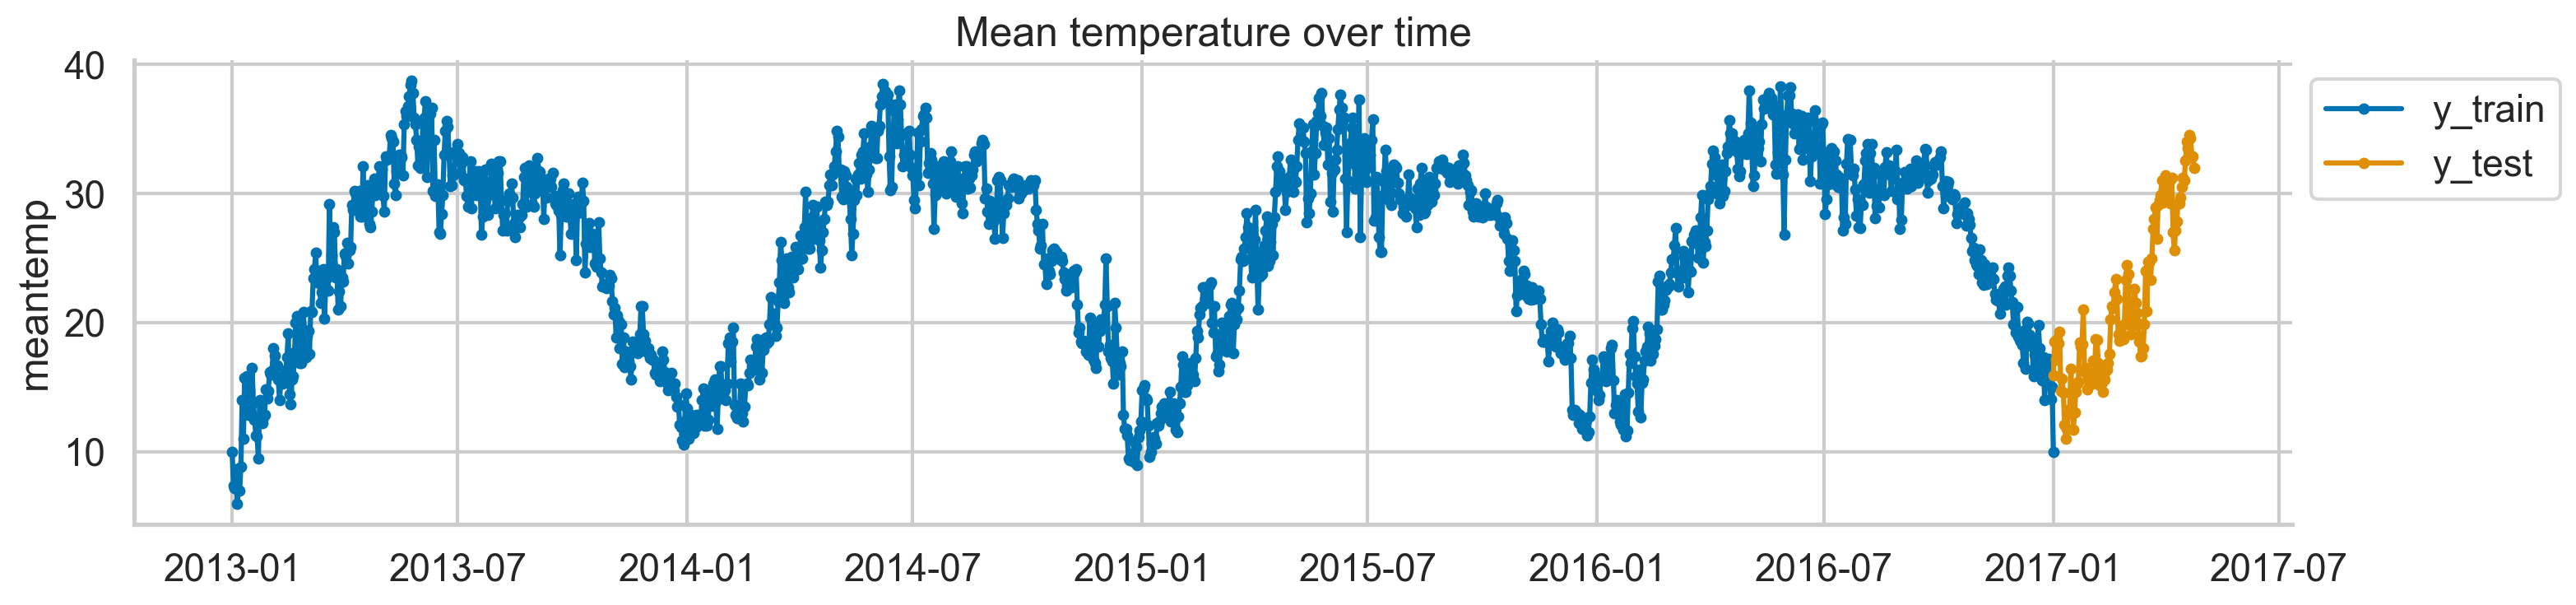

In [13]:
TARGET = "meantemp"

fig, ax = plot_series(
    train_df[[TARGET]], test_df[[TARGET]],
    labels=["y_train", "y_test"]
)
ax.set_title("Mean temperature over time")
ax.legend(bbox_to_anchor=(1, 1), loc=2)
sns.despine()
plt.tight_layout()

# Time series analysis

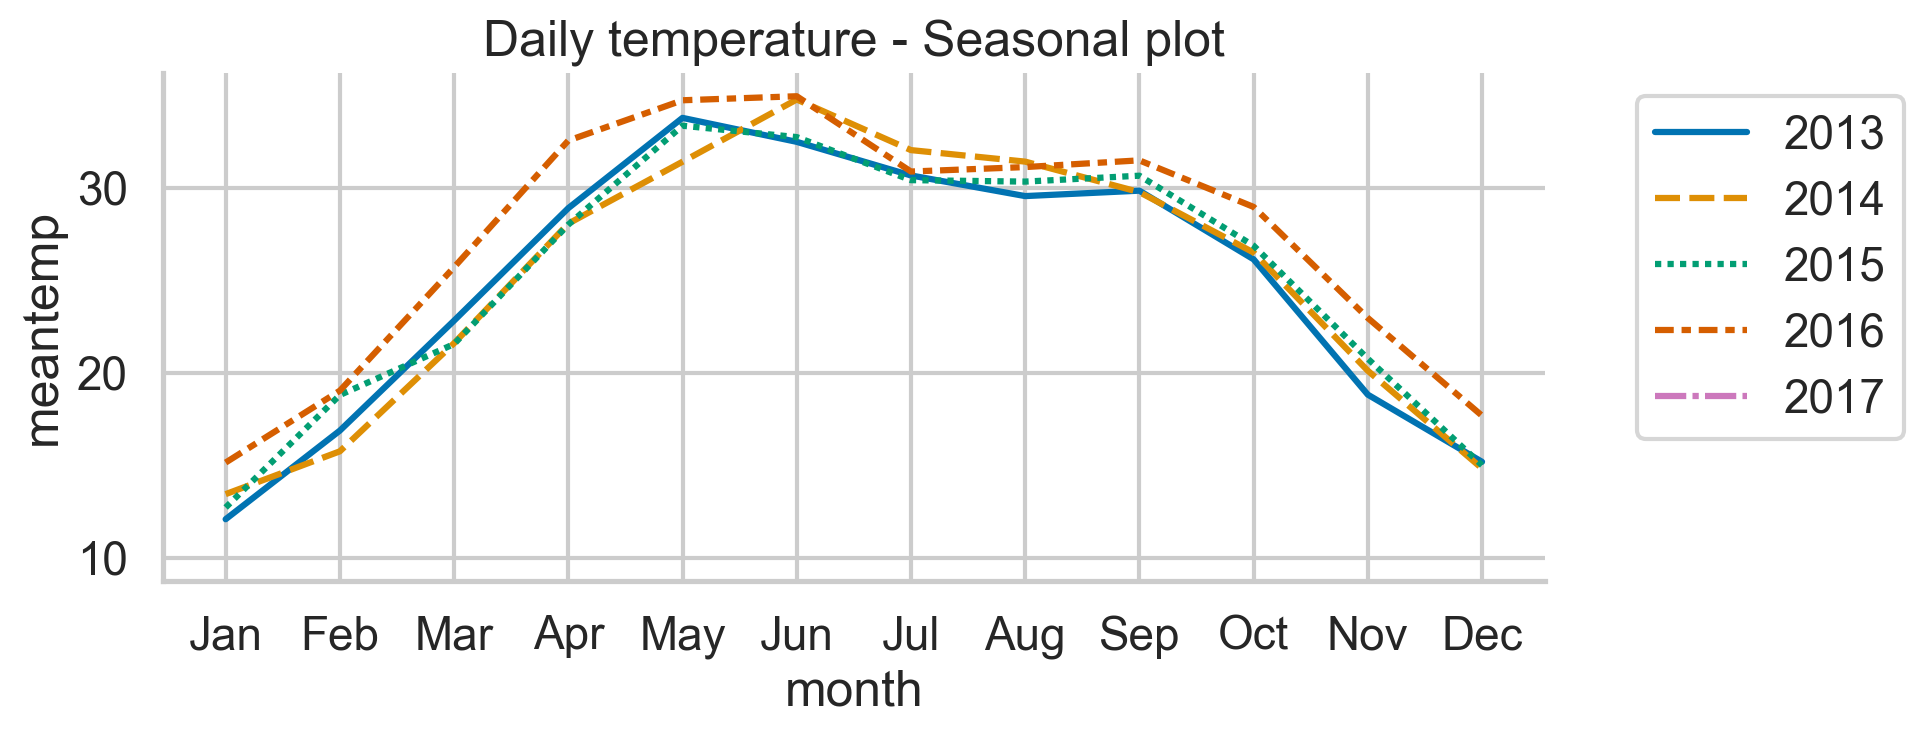

In [4]:
temp_df = train_df[["meantemp"]].copy()
monthly_temp_df = temp_df.resample("M").mean()
monthly_temp_df["year"] = monthly_temp_df.index.year
monthly_temp_df["month"] = monthly_temp_df.index.strftime("%b")

sns.lineplot(data=monthly_temp_df, x="month", y="meantemp", hue="year", style="year", legend="full", palette="colorblind")
plt.title("Daily temperature - Seasonal plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

sns.despine()
plt.tight_layout()

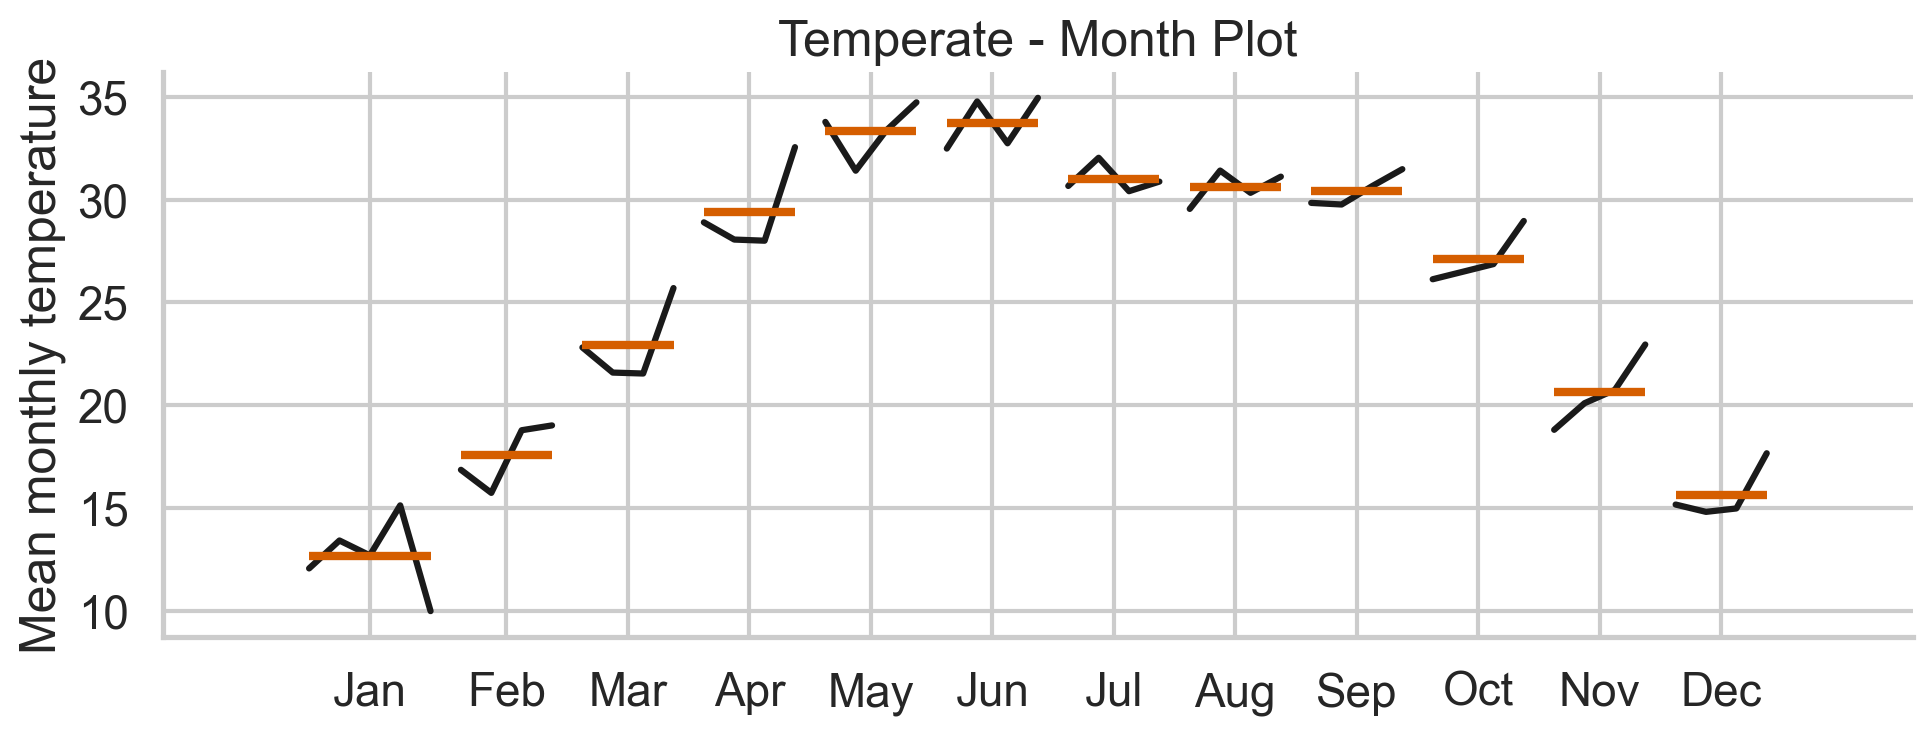

In [5]:
month_plot(monthly_temp_df["meantemp"], ylabel="Mean monthly temperature")
plt.title("Temperate - Month Plot")

sns.despine()
plt.tight_layout()

In [14]:
fig = px.line_polar(
    monthly_temp_df, r="meantemp", theta="month",
    color="year", 
    line_close=True,
    title="Temperature - Polar seasonal plot",
    width=900, height=500,
    range_r=[10, 35]
)
fig.show()

# Feature engineering

In [ ]:
print(rbf_func.__doc__)


    Adds repeating basis function (RBF) features to training and test dataframes based on day-of-year.
    
    Parameters:
        df_train (pd.DataFrame): Training dataframe with a datetime index.
        df_test (pd.DataFrame): Test dataframe with a datetime index.
        n_periods (int): Number of repeating basis functions.

    Returns:
        pd.DataFrame: Transformed training dataframe with RBF features.
        pd.DataFrame: Transformed test dataframe with RBF features.
    


In [ ]:
df_train, df_test = rbf_func(train_df, test_df, n_periods=12)

In [9]:
N_LAGS = 7
lagger = LagFeatureGenerator(target_col=TARGET, n_lags=N_LAGS)
df_train_with_lags = lagger.transform(df_train)
df_train_with_lags.dropna(inplace=True)

# Modelling

In [10]:
TEST_LENGTH = len(test_df)
RANDOM_STATE = 42
N_FOLDS = 5

y = df_train_with_lags[[TARGET]]
X = df_train_with_lags.drop(columns=[TARGET])


def get_stacking():
    level0 = [
    ("svm", make_pipeline(StandardScaler(), SVR())),
    ("random forest", RandomForestRegressor(random_state=RANDOM_STATE)),
    ("lgbm", LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)),
    ("xgb", XGBRegressor(random_state=RANDOM_STATE))
    ]
    level1 = Ridge()
    stacking_ensemble = StackingRegressor(estimators=level0, final_estimator=level1)
    return stacking_ensemble

def get_models():
    models = {}
    models["svm"] = make_pipeline(StandardScaler(), SVR())
    models["random forest"] = RandomForestRegressor()
    models["lgbm"] = LGBMRegressor(verbose=-1)
    models["xgb"] = XGBRegressor()
    models["ensemble"] = get_stacking()
    return models

def evaluate_model(X, y, model):
    cv = TimeSeriesSplit(n_splits=N_FOLDS, test_size=TEST_LENGTH)
    cv_scores = cross_validate(
        model,
        X, y, 
        cv=cv, 
        scoring={
            "mape": "neg_mean_absolute_percentage_error",
            "rmse": "neg_root_mean_squared_error",
            "r2": "r2"
        },
        return_train_score=False
    )
    mape = -1 * cv_scores["test_mape"]
    rmse = -1 * cv_scores["test_rmse"]
    r2 = cv_scores["test_r2"]
    return mape.mean(), rmse.mean(), r2.mean()

models = get_models()

scores = defaultdict(list)
for name, model in tqdm(models.items(), ncols=100, desc="Model Eval..."):
    params = model.get_params()
    if "n_jobs" in params:
        model.set_params(n_jobs=-1)
    if "random_state" in params:
        model.set_params(random_state=RANDOM_STATE)
    mape, rmse, r2 = evaluate_model(X, y.values.ravel(), model)
    scores_dict = {"mape": mape, "rmse": rmse, "r2": r2}
    scores["model"].append(name)
    for score_name, score in scores_dict.items():
        scores[score_name].append(score)
    
    scores_df = pd.DataFrame(scores).set_index("model")
    scores_df.round(decimals=4)
print(scores_df)

Model Eval...: 100%|██████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.83s/it]

                   mape      rmse        r2
model                                      
svm            0.050039  1.561059  0.816954
random forest  0.044820  1.419221  0.812331
lgbm           0.046656  1.461226  0.811515
xgb            0.049887  1.602426  0.777159
ensemble       0.045369  1.417528  0.830223


# Model evaluation

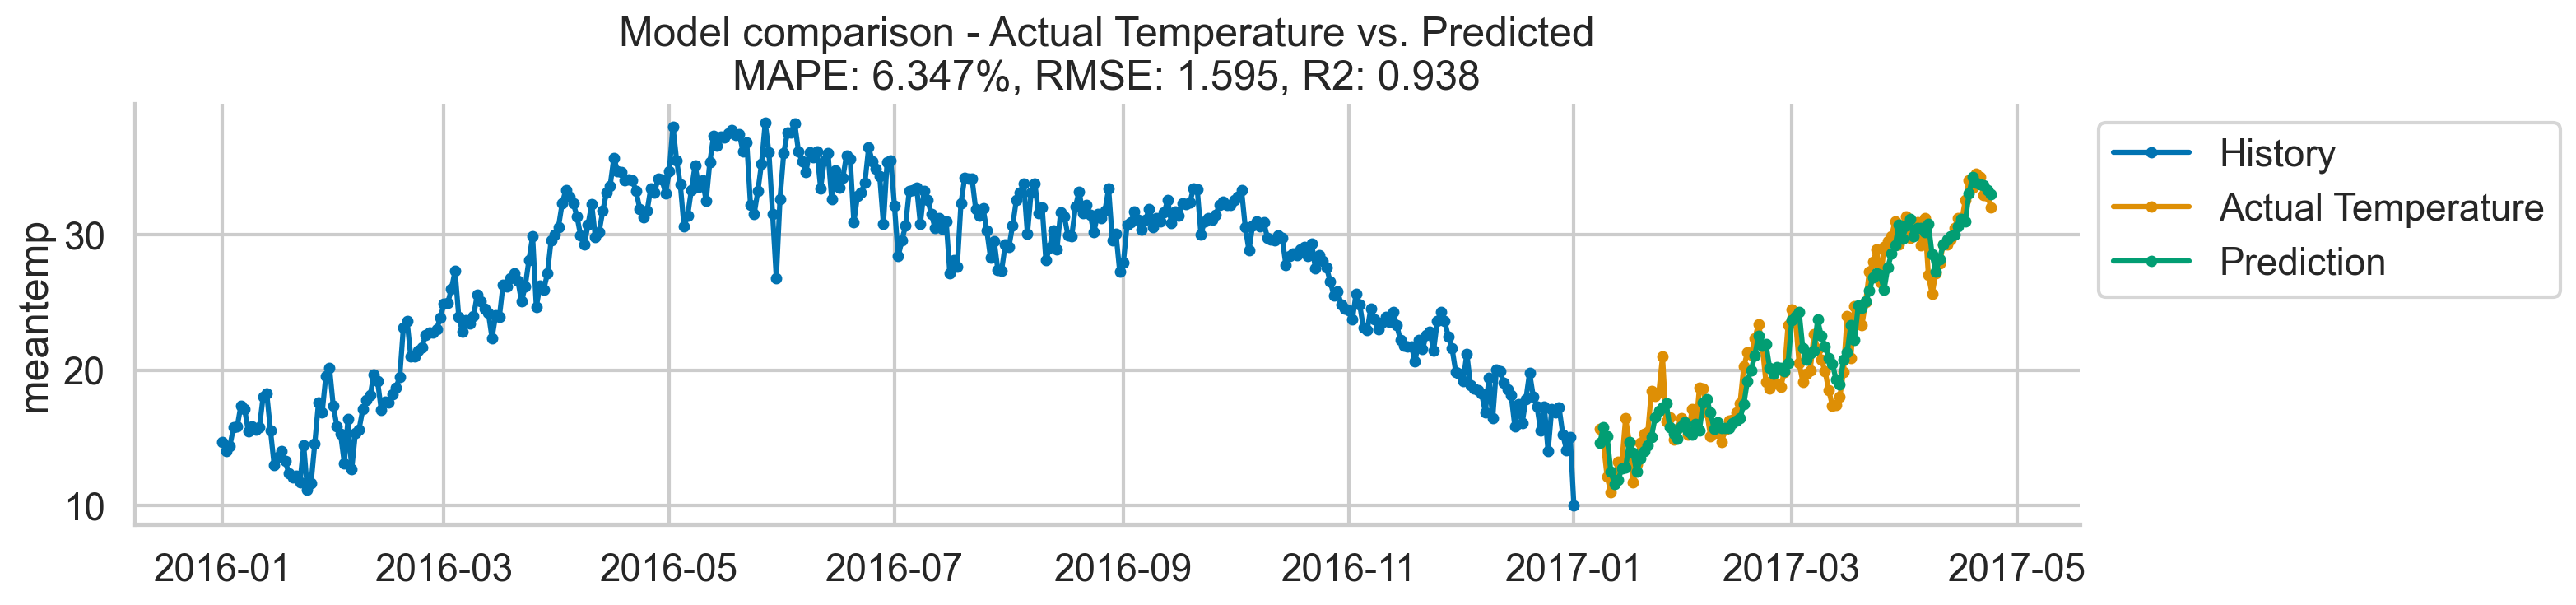

In [11]:
model = get_stacking()
model.fit(X, y.values.ravel())

df_test_with_lags = lagger.transform(df_test)
df_test_with_lags.dropna(inplace=True)

y_test = df_test_with_lags[[TARGET]]
X_test = df_test_with_lags.drop(columns=[TARGET])

y_pred = pd.DataFrame(data=model.predict(X_test), index=y_test.index)

mape, rmse, r2 =\
mean_absolute_percentage_error(y_test, y_pred), root_mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)
fig, ax = plot_series(
    y["2016":], y_test, y_pred,
    labels=["History", "Actual Temperature", "Prediction"]

)
ax.set_title(f"Model comparison - Actual Temperature vs. Predicted\nMAPE: {100*mape:.3f}%, RMSE: {rmse:.3f}, R2: {r2:.3f}")
ax.legend(bbox_to_anchor=(1, 1), loc=2)

sns.despine()
plt.tight_layout()

# Conclusion and further work...

Our model yielded impressive results as indicated by the out-of-sample MAPE, RMSE, and R2 scores of 6.347%, 1.595, and 0.938, respectively. The results clearly outperform the majority of work on this dataset showcased on Kaggle.

For reference, please follow: 

https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/code